In [1]:
import numpy as np
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from figure_formatting import figure_formatting as ff
# 
ff.set_formatting()

colors = {'blue': '#264653',
          'green': '#2A9D8F',
          'yellow': '#E9C46A',
          'light orange': '#F4A261',
          'dark orange': '#E76F51'}

In [2]:
@dataclass
class Cluster:
    "Class for a MAPS cluster expansion model cluster"
    degeneracy: int
    radius: float
    coords: np.ndarray
    eci: float
        
    @property
    def size(self) -> int:
        return self.coords.shape[0]

In [3]:
with open('../Data/clusters.out', 'r') as f:
    cluster_data = [chunk.split('\n') for chunk in f.read().strip().split('\n\n')]
    
with open('../Data/eci.out', 'r') as f:
    eci_data = [float(line.strip()) for line in f.readlines()]
    
clusters = []
for cd, eci in zip(cluster_data, eci_data):
    cluster = Cluster(degeneracy = int(cd[0]),
                      radius = float(cd[1]),
                      coords = np.array([[float(s) for s in line.split()] for line in cd[3:]]),
                      eci = eci)
    clusters.append(cluster)

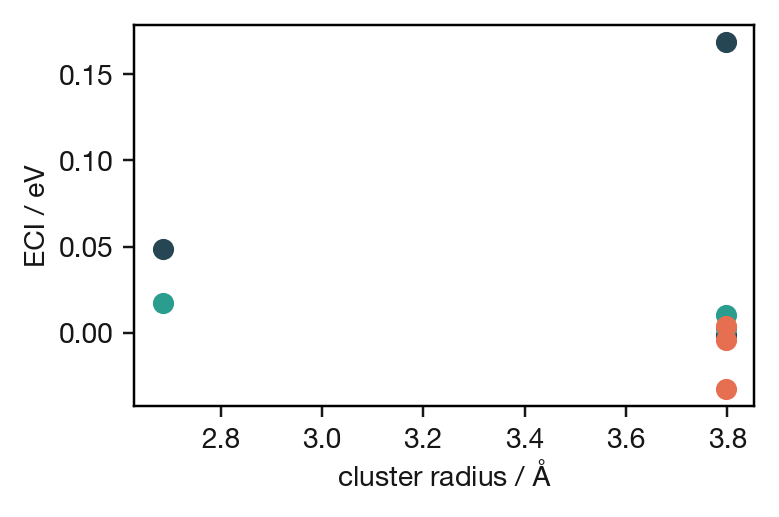

In [4]:
cluster_colours = {2: colors['blue'],
                   3: colors['green'],
                   4: colors['dark orange']}
plt.figure()
for c in clusters:
    if len(c.coords) > 1:
        plt.plot(c.radius, c.eci, 'o', color=cluster_colours[len(c.coords)])
plt.xlabel('cluster radius / $\AA$')
plt.ylabel('ECI / eV')
# plt.legend()
plt.show()

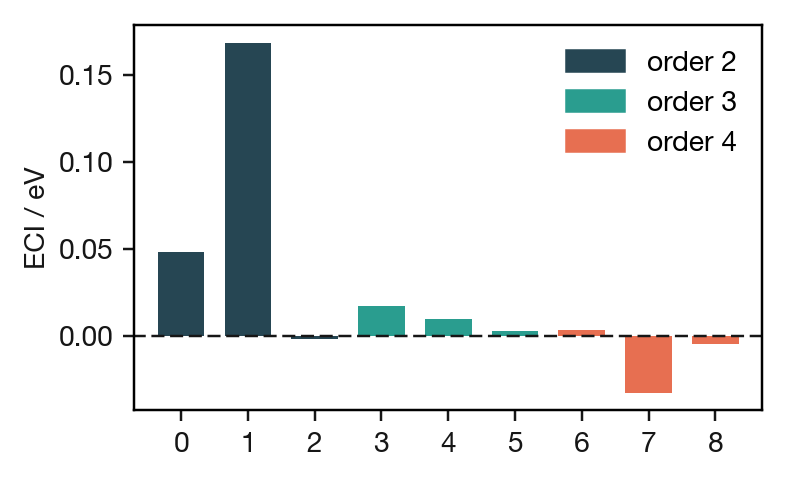

In [5]:
import matplotlib.patches as mpatches

frame1 = plt.gca()
clusters.sort(key=lambda x: x.size)
to_plot = [c for c in clusters if c.size > 1]
plt.bar(np.arange(len(to_plot)), [c.eci for c in to_plot], color=[cluster_colours[c.size] for c in to_plot], width=0.7)
# plt.xlabel('clusters')
plt.ylabel('ECI / eV')
patches = [mpatches.Patch(color=cluster_colours[i], label=f'order {i}') for i in [2, 3, 4]]
plt.xticks(np.arange(9))
# plt.xticks([])
frame1.axes.xaxis.set_ticklabels(np.arange(len(to_plot)))
plt.hlines(0.0, -1.0, 10.0, linestyle='--', color=ff.nearly_black)
plt.xlim(-0.7, 8.7)
# plt.xticklabels([])

plt.legend(handles=patches)
plt.tight_layout()
plt.savefig('../Figures/ecis.pdf')
plt.show()

In [6]:
from pymatgen.core import Lattice, Structure, PeriodicSite 

def cluster_to_structure(cluster):
    Ti_coords = np.array([[0.0, 0.0, 0.0],
                      [0.0, 0.5, 0.0],
                      [0.5, 0.0, 0.0],
                      [0.0, 0.0, 0.5],
                      [0.5, 0.5, 0.0],
                      [0.0, 0.5, 0.5],
                      [0.5, 0.0, 0.5],
                      [0.5, 0.5, 0.5]])
        
    a = 3.798000
    lattice = Lattice.from_parameters(a=a*2, b=a*2, c=a*2, alpha=90.0, beta=90.0, gamma=90.0)
    sites = []
    for coord in c.coords:
        sites.append(PeriodicSite(species='O',
                 coords=np.array(coord/2),
                 lattice=lattice))
    cluster_structure = Structure.from_sites(sites=sites)
    for coords in Ti_coords:
        cluster_structure.append(species='Ti',
                                 coords=coords)
   
    return cluster_structure

for i, c in enumerate(to_plot):
    cluster_to_structure(c).to(filename=f'clusters/cluster_{i}.cif', fmt='cif')